# Stock price Predictor & Portfolio Optimization
Investment firms, hedge funds and even individuals have been using financial models to better understand market behavior and make profitable investments and trades. A wealth of information is available in the form of historical stock prices and company performance data, suitable for machine learning algorithms to process.

In [ ]:
pip install -r requirements.txt

In [1]:
# import libraries 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import requests
import pandas_datareader as web
import yfinance as yf
import math
%matplotlib inline
import time 
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
# py Portfolio Optimization 
from pypfopt.expected_returns import mean_historical_return
from pypfopt import risk_models,objective_functions
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import warnings
warnings.filterwarnings("ignore")

In [2]:
# get the tickers from nasdaq for mage and large companies
def get_tickers():
    df = pd.read_csv('nasdaq_screener.csv')['Symbol']
    return df.tolist()
all_tickers = get_tickers()

In [3]:
# Adjusted close for all tickers
def get_data(tickers):
  
    start_year = date.today().year-6
    start_date = str('{}-01-01'.format(start_year))
    end_date = date.today().strftime("%Y-%m-%d")

    df = yf.download(tickers, start_date, end_date) 
    return df['Adj Close']

In [4]:
df = get_data(all_tickers)

[*********************100%***********************]  193 of 193 completed


In [5]:
# fill nan value 
df.fillna(axis=1,method='ffill',inplace=True)
df.fillna(axis=1,method='bfill',inplace = True)

## How each sector perform in the pandemic

In [23]:
pandemic_data = df['2020-01-01':'2022-01-01']

In [24]:
# preprocessing data for visualizing 
BCES = pd.read_csv('nasdaq_screener.csv')
BCES1=  pd.merge(BCES[['Sector','Symbol']],pandemic_data.T.reset_index().rename(columns={'index':'Symbol'}),how='right',on='Symbol')\
.set_index(['Sector','Symbol'])
BCES1

2020-01-02  2020-01-03  2020-01-06  2020-01-07  \
Sector                 Symbol                                                   
Technology             AAPL     73.561546   72.846359   73.426811   73.081505   
Health Care            ABMD    168.809998  166.820007  179.039993  180.350006   
Consumer Discretionary ABNB    168.809998  166.820007  179.039993  180.350006   
Technology             ADBE    334.429993  331.809998  333.709991  333.390015   
                       ADI     113.905487  111.900352  110.585663  113.101562   
...                                   ...         ...         ...         ...   
Utilities              XEL      57.911705   58.190212   58.106667   57.985973   
Technology             ZBRA    259.140015  256.049988  258.010010  256.470001   
                       ZI      259.140015  256.049988  258.010010  256.470001   
                       ZM       68.720001   67.279999   70.320000   71.900002   
                       ZS       47.330002   47.380001   48.700001   48.400002   

                               2020-01-08  2020-01-09  2020-01-10  2020-01-13  \
Sector                 Symbol                                                   
Technology             AAPL     74.257118   75.834389   76.005829   77.629639   
Health Care            ABMD    178.690002  183.600006  189.059998  168.100006   
Consumer Discretionary ABNB    178.690002  183.600006  189.059998  168.100006   
Technology             ADBE    337.869995  340.450012  339.809998  345.630005   
                       ADI     114.123039  114.123039  112.146255  112.609718   
...                                   ...         ...         ...         ...   
Utilities              XEL      57.930279   58.060242   58.153076   58.830788   
Technology             ZBRA    247.639999  246.500000  246.270004  248.580002   
                       ZI      247.639999  246.500000  246.270004  248.580002   
                       ZM       72.550003   72.620003   73.089996   74.029999   
                       ZS       50.750000   54.000000   55.000000   59.619999   

                               2020-01-14  2020-01-15  ...  2021-12-17  \
Sector                 Symbol                          ...               
Technology             AAPL     76.581383   76.253204  ...  170.152466   
Health Care            ABMD    172.729996  177.919998  ...  315.549988   
Consumer Discretionary ABNB    172.729996  177.919998  ...  157.910004   
Technology             ADBE    344.630005  342.940002  ...  556.640015   
                       ADI     113.054253  111.143692  ...  166.949066   
...                                   ...         ...  ...         ...   
Utilities              XEL      58.923626   59.851997  ...   65.183388   
Technology             ZBRA    248.070007  247.800003  ...  588.520020   
                       ZI      248.070007  247.800003  ...   62.730000   
                       ZM       73.160004   76.940002  ...  199.740005   
                       ZS       59.540001   59.990002  ...  304.869995   

                               2021-12-20  2021-12-21  2021-12-22  2021-12-23  \
Sector                 Symbol                                                   
Technology             AAPL    168.770493  171.991791  174.626495  175.262802   
Health Care            ABMD    316.230011  332.200012  343.399994  352.209991   
Consumer Discretionary ABNB    157.229996  165.660004  169.289993  171.309998   
Technology             ADBE    549.770020  557.520020  563.979980  569.619995   
                       ADI     165.192337  168.882477  169.088562  169.451675   
...                                   ...         ...         ...         ...   
Utilities              XEL      65.300140   64.984711   65.366753   65.249199   
Technology             ZBRA    570.780029  580.210022  580.429993  582.409973   
                       ZI       61.320000   64.580002   64.900002   65.720001   
                       ZM      197.970001  199.419998  193.130005  19

In [25]:
df1 = BCES1.groupby(['Sector']).mean().T
df1

Sector      Basic Materials  Consumer Discretionary  Consumer Staples  \
2020-01-02        34.411755              150.009759         57.741906   
2020-01-03        33.801716              149.395973         57.585885   
2020-01-06        33.274864              149.475932         57.783164   
2020-01-07        33.210163              149.849660         57.220908   
2020-01-08        33.459721              150.514730         56.766306   
...                     ...                     ...               ...   
2021-12-27        62.074051              205.875998         73.945442   
2021-12-28        62.366943              205.453546         74.375756   
2021-12-29        62.894154              205.907762         74.871976   
2021-12-30        62.298603              205.951681         74.663324   
2021-12-31        62.542675              205.661640         75.127001   

Sector         Energy     Finance  Health Care  Industrials  Real Estate  \
2020-01-02  39.725860  135.046585   147.254161    88.918388   161.905279   
2020-01-03  40.071862  134.402880   146.086201    88.144113   163.403870   
2020-01-06  40.141175  133.681833   147.908884    87.636535   163.240372   
2020-01-07  42.011181  133.747865   147.654255    87.867168   162.007652   
2020-01-08  41.336972  133.497770   148.942633    88.162891   162.926027   
...               ...         ...          ...          ...          ...   
2021-12-27  53.746246  211.448817   226.758233   162.369727   241.019228   
2021-12-28  53.521850  210.456668   225.649232   162.372701   241.798194   
2021-12-29  53.013877  208.890593   227.965054   163.472283   242.726641   
2021-12-30  52.124077  207.229121   227.991423   162.086330   244.383500   
2021-12-31  52.273855  208.033916   226.388668   162.772853   244.439037   

Sector      Technology  Telecommunications  Utilities  
2020-01-02  110.985927           70.424459  62.365625  
2020-01-03  110.158006           70.415781  62.107422  
2020-01-06  110.734639           70.652268  62.011530  
2020-01-07  111.362158           70.806174  62.079539  
2020-01-08  112.056666           70.908054  62.073946  
...                ...                 ...        ...  
2021-12-27  223.817161           91.164978  79.231415  
2021-12-28  221.048634           91.419141  79.409990  
2021-12-29  221.036981           91.380869  79.844394  
2021-12-30  220.172799           91.160958  79.574097  
2021-12-31  218.898556           90.515361  79.695093  

[505 rows x 11 columns]

In [26]:
px.line(df1, labels={"index":'Date',"value": "Adj Close Price"}
        ,title = "Adj close prices for mega and large INC. in each sector")

In [27]:
df1 = df1/df1.iloc[0,:] # for cumulative return
df1

Sector      Basic Materials  Consumer Discretionary  Consumer Staples  \
2020-01-02         1.000000                1.000000          1.000000   
2020-01-03         0.982272                0.995908          0.997298   
2020-01-06         0.966962                0.996441          1.000715   
2020-01-07         0.965082                0.998933          0.990977   
2020-01-08         0.972334                1.003366          0.983104   
...                     ...                     ...               ...   
2021-12-27         1.803862                1.372417          1.280620   
2021-12-28         1.812373                1.369601          1.288072   
2021-12-29         1.827694                1.372629          1.296666   
2021-12-30         1.810387                1.372922          1.293053   
2021-12-31         1.817480                1.370988          1.301083   

Sector        Energy   Finance  Health Care  Industrials  Real Estate  \
2020-01-02  1.000000  1.000000     1.000000     1.000000     1.000000   
2020-01-03  1.008710  0.995233     0.992068     0.991292     1.009256   
2020-01-06  1.010455  0.989894     1.004446     0.985584     1.008246   
2020-01-07  1.057527  0.990383     1.002717     0.988178     1.000632   
2020-01-08  1.040556  0.988531     1.011466     0.991503     1.006305   
...              ...       ...          ...          ...          ...   
2021-12-27  1.352928  1.565747     1.539911     1.826053     1.488643   
2021-12-28  1.347280  1.558401     1.532379     1.826087     1.493455   
2021-12-29  1.334493  1.546804     1.548106     1.838453     1.499189   
2021-12-30  1.312094  1.534501     1.548285     1.822866     1.509423   
2021-12-31  1.315865  1.540460     1.537401     1.830587     1.509766   

Sector      Technology  Telecommunications  Utilities  
2020-01-02    1.000000            1.000000   1.000000  
2020-01-03    0.992540            0.999877   0.995860  
2020-01-06    0.997736            1.003235   0.994322  
2020-01-07    1.003390            1.005420   0.995413  
2020-01-08    1.009648            1.006867   0.995323  
...                ...                 ...        ...  
2021-12-27    2.016627            1.294507   1.270434  
2021-12-28    1.991682            1.298116   1.273297  
2021-12-29    1.991577            1.297573   1.280263  
2021-12-30    1.983790            1.294450   1.275929  
2021-12-31    1.972309            1.285283   1.277869  

[505 rows x 11 columns]

In [28]:
px.line(df1, labels={"index":'Date',"value": "cumulative return"}
        ,title = "Mean Adj close prices for mega and large INC. in each sector Cumulated")

In [29]:
FANNG = pandemic_data[['META','AAPL','AMZN','NFLX','GOOGL']]
FANNG = FANNG / FANNG.iloc[0,:]

In [30]:
px.line(FANNG,labels={"value":'Cumulative Return',"variable": "ticker"}
        ,title = "FANNG stocks Cumulative Return")

## For Sectors
all sectors have been affected by the pandemic, but there are some sectors affected most, like the energy sector and this makes sense because all countries were closed.
The energy sector recovered after 1 year, and most of the sectors recovered after about 6 months.
Health care, Real estate, and basic material recovered fast than others, and after 1 year the technology sector is booming with industrial and basic material sectors. 
And as we see, the basic materials, utilities and customer staples were less affected.
## For FANNG stocks
Meta, google, and apple suffered most than Netflix and amazon in the market.
Netflix and Amazon recovered fast and the two companies are in the customer discretionary sector.

## Data Preprocessing

In [6]:
FANNG = ['META','AAPL','AMZN','NFLX','GOOGL']
FAANG = get_data(FANNG)


[*********************100%***********************]  5 of 5 completed


In [7]:
def data_prep(data,ticker,time_step=60):
    ticker = ticker.upper()
    df = data.filter([ticker]).values # filter the data by ticker
    X= []
    y =[]
    for i in range(len(df)-time_step): # pre_processing
        X.append(df[i:time_step + i,0]) # features numbers = time_step
        y.append(df[i+time_step,0]) 

    # covnert to array
    X,y = np.array(X),np.array(y) 

    return X,y

In [8]:
def split_data(X,y,split_percentage=0.75):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-split_percentage,shuffle=False)
    return X_train, X_test, y_train, y_test

In [9]:
def scale_data(X_train, X_test, y_train,y_test,time_step=60):
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(X_train)
    y_train = scaler.fit_transform(y_train.reshape(-1,1))
    X_test = scaler.fit_transform(X_test)
    y_test = scaler.fit_transform(y_test.reshape(-1,1))
    return X_train, X_test, y_train,y_test, scaler

In [10]:
def plot_result(data, ticker,predictions,training_shape,model,time_step=60):
    ticker = ticker.upper()
    data = data.filter([ticker])
    train = data[:training_shape+time_step+1]
    test = data[training_shape+time_step:]
    test['predictions'] = predictions
    plt.figure(figsize=(15,8))
    plt.plot(train[ticker])
    plt.plot(test[[ticker,'predictions']])
    plt.legend(['trian','Val','val_pred'])
    plt.xlabel('Date')
    plt.ylabel('Adj close Price')
    plt.title(f'{model} {ticker} Stock prediction');

In [11]:
def build_lr(df, ticker):
    X, y = data_prep(df,ticker)
    X_train, X_test, y_train, y_test = split_data(X,y)
    X_train, X_test, y_train,y_test, scaler = scale_data(X_train, X_test, y_train,y_test)
    LR = LinearRegression()
    tic = time.time()
    LR.fit(X_train, y_train)
    tac = time.time()
    predictions = LR.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1))
    y_test1 = scaler.inverse_transform(y_test)
    MSE = mean_squared_error(y_test1, predictions)
    print('MSE : ', MSE)
    print(f'LR Model Take {math.ceil(tac-tic)} Sec')
    #print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
    return predictions, X_train.shape[0], LR,X_test,y_test,scaler

In [12]:
def build_LSTM(df, ticker):
    X, y = data_prep(df,ticker)
    X_train, X_test, y_train, y_test = split_data(X,y)
    X_train, X_test, y_train,y_test, scaler = scale_data(X_train, X_test, y_train,y_test)
    # reshape the data to be 3D for LSTM model
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    X_test = np.reshape(X_test , (X_test.shape[0],X_test.shape[1],1))

  #Build LSTM model
    model=Sequential()
    model.add(LSTM(128,return_sequences=True,input_shape=(X_train.shape[1],1)))
    model.add(LSTM(64))
    model.add(Dense(50))
    model.add(Dense(1))
    # compile the model and train
    model.compile(optimizer='adam', loss = 'mean_squared_error')
    #earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=5)
    #model.fit(X_train,y_train,epochs=100,batch_size=32,validation_data=(X_test,y_test),callbacks=[earlyStop])
    print('Training....')
    tic = time.time()
    model.fit(X_train,y_train,epochs=20,batch_size=8,verbose=0)
    tac = time.time()
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1))
    y_test1 = scaler.inverse_transform(y_test)
    MSE = mean_squared_error(y_test1, predictions)
    print('MSE : ', MSE)
    print(f'LSTM Model Take {math.ceil(tac-tic)} Sec')
    return predictions, X_train.shape[0],LSTM,X_test,y_test,scaler

## Training models

MSE :  61.69505302036034
LR Model Take 1 Sec


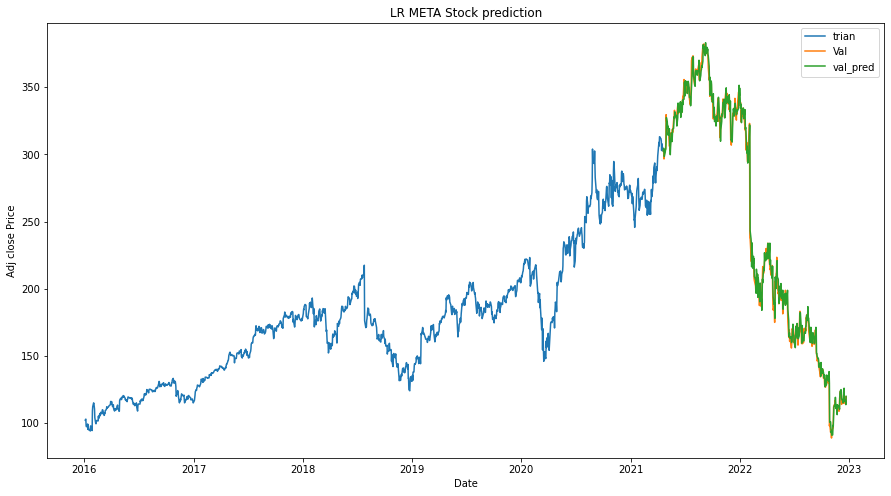

In [ ]:
predictions,split_index,LR,X_test,y_test,scaler = build_lr(FAANG,'meta')
plot_result(FAANG,'meta',predictions ,split_index,'LR')

Training....
14/14 [==============================] - 1s 41ms/step
MSE :  57.16863528743344
LSTM Model Take 174 Sec


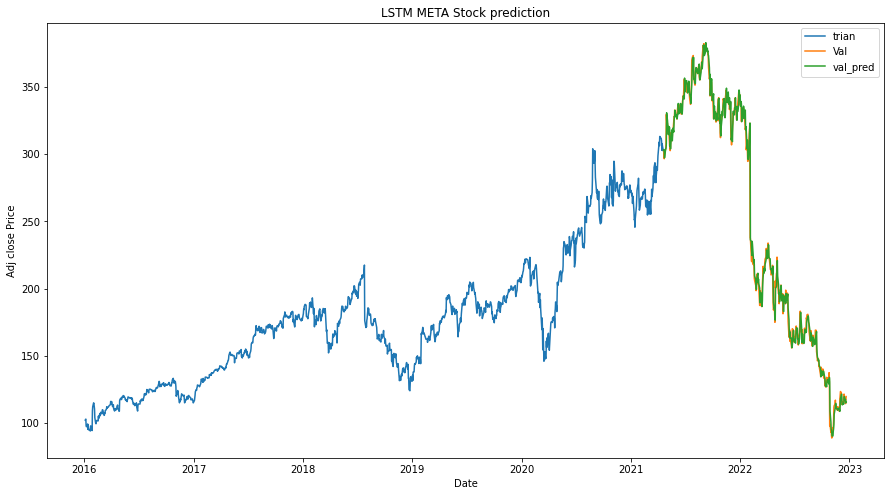

In [ ]:
predictions,split_index,LSTM,X_test,y_test,scaler = build_LSTM(FAANG,'meta')
plot_result(FAANG,'meta',predictions ,split_index,'LSTM')

MSE :  9.240025707760518
LR Model Take 1 Sec


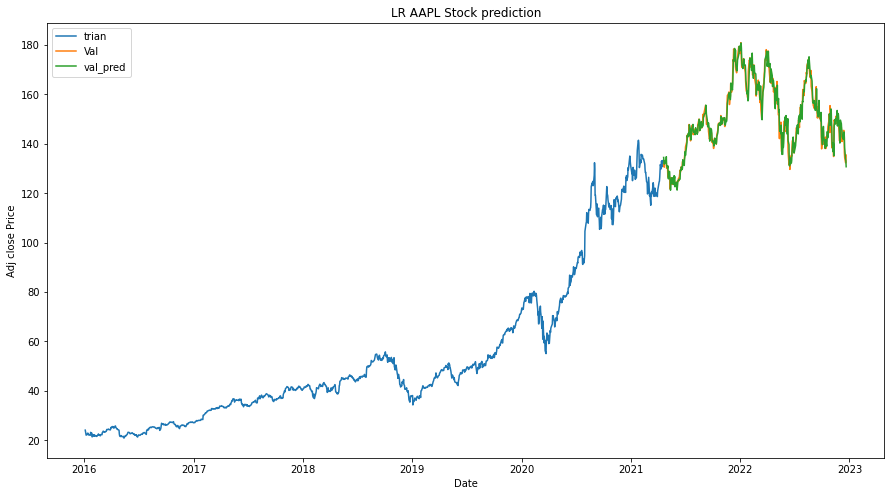

In [ ]:
predictions,split_index,LR,X_test,y_test,scaler = build_lr(FAANG,'aapl')
plot_result(FAANG,'aapl',predictions ,split_index,'LR')

Training....
14/14 [==============================] - 2s 38ms/step
MSE :  9.532977231229212
LSTM Model Take 205 Sec


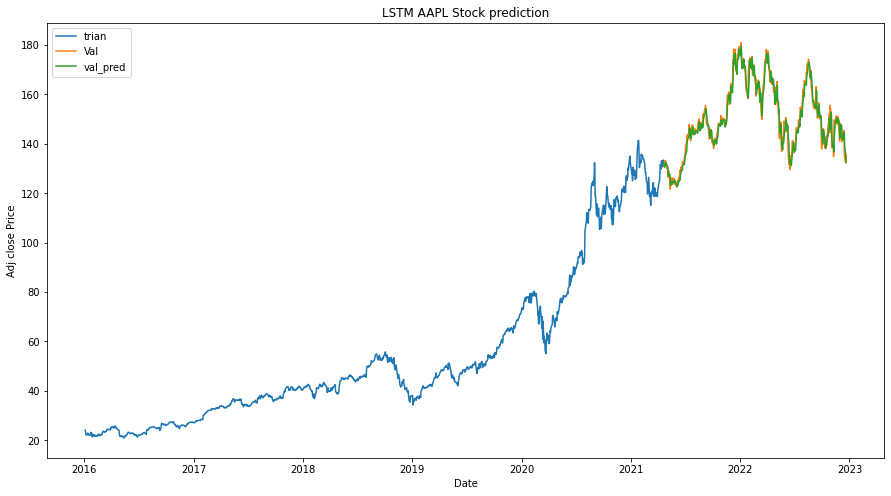

In [ ]:
predictions,split_index,LSTM,X_test,y_test,scaler = build_LSTM(FAANG,'aapl')
plot_result(FAANG,'aapl',predictions ,split_index,'LSTM')

MSE :  13.953507909063525
LR Model Take 1 Sec


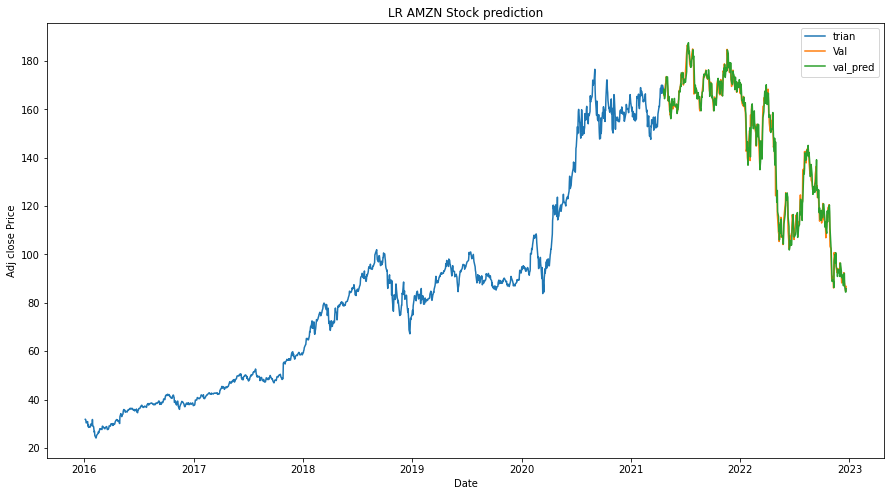

In [ ]:
predictions,split_index,LR,X_test,y_test,scaler = build_lr(FAANG,'amzn')
plot_result(FAANG,'amzn',predictions ,split_index,'LR')

Training....
14/14 [==============================] - 2s 53ms/step
MSE :  15.369023641495627
LSTM Model Take 175 Sec


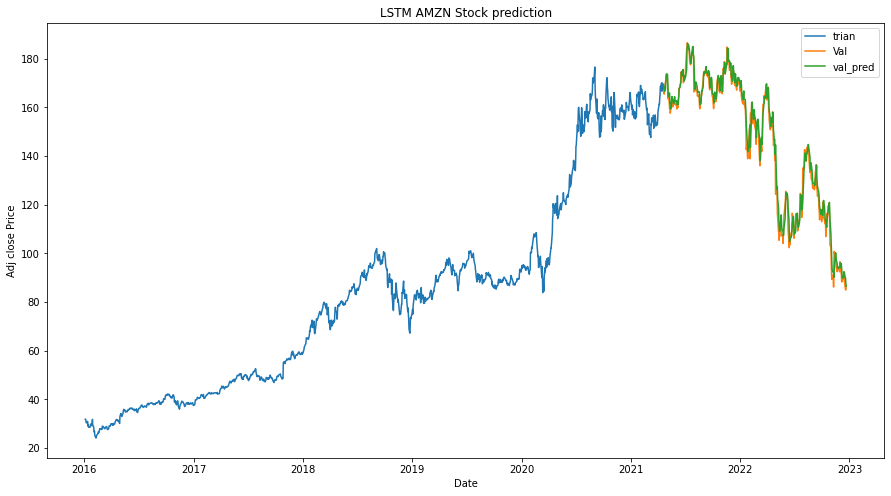

In [ ]:
predictions,split_index,LSTM,X_test,y_test,scaler = build_LSTM(FAANG,'amzn')
plot_result(FAANG,'amzn',predictions ,split_index,'LSTM')

MSE :  182.82522576074552
LR Model Take 1 Sec


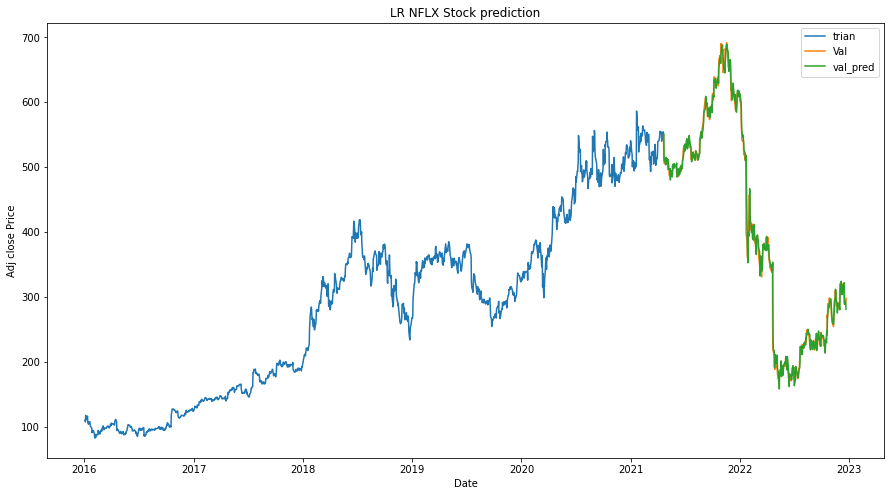

In [ ]:
predictions,split_index,LR,X_test,y_test,scaler = build_lr(FAANG,'nflx')
plot_result(FAANG,'nflx',predictions ,split_index,'LR')

Training....
14/14 [==============================] - 1s 38ms/step
MSE :  220.91215387702138
LSTM Model Take 184 Sec


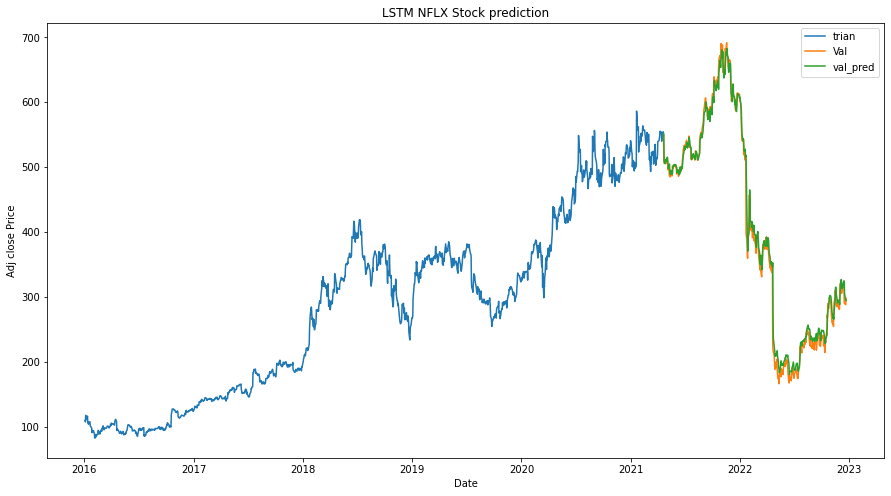

In [ ]:
predictions,split_index,LSTM,X_test,y_test,scaler = build_LSTM(FAANG,'nflx')
plot_result(FAANG,'nflx',predictions ,split_index,'LSTM')

MSE :  6.658735372888752
LR Model Take 1 Sec


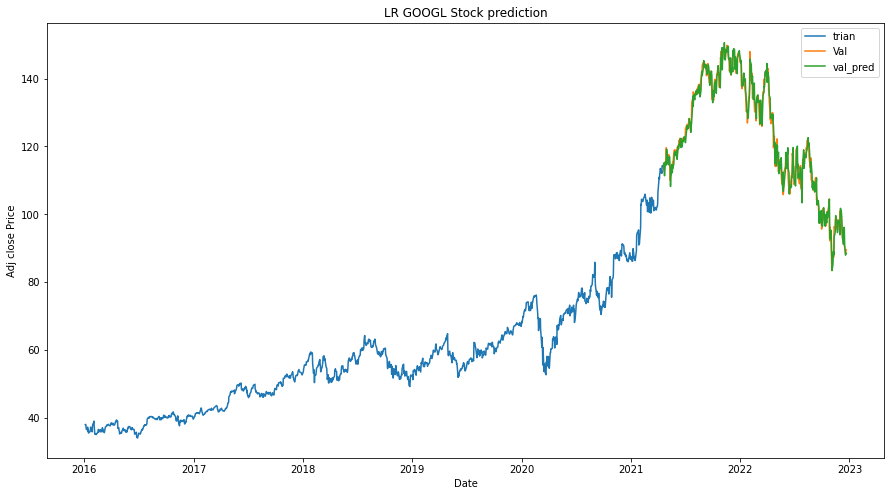

In [ ]:
predictions,split_index,LR,X_test,y_test,scaler = build_lr(FAANG,'googl')
plot_result(FAANG,'googl',predictions ,split_index,'LR')

Training....
14/14 [==============================] - 1s 39ms/step
MSE :  6.125015813108856
LSTM Model Take 172 Sec


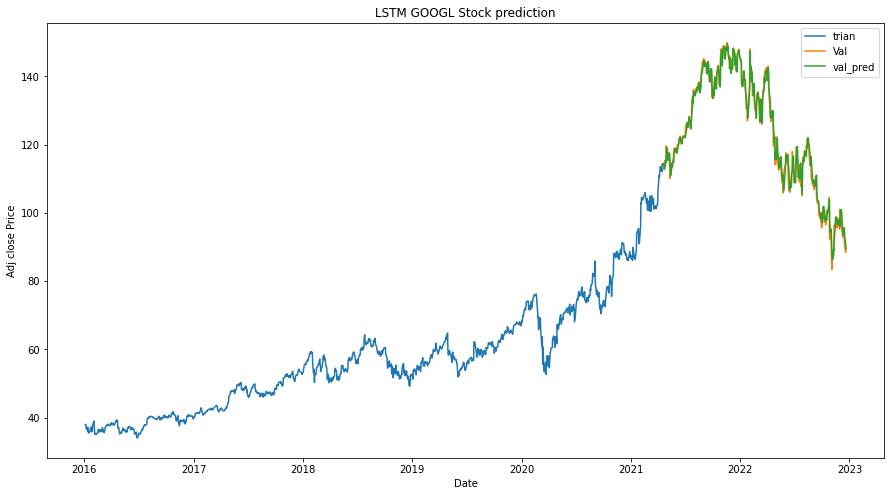

In [ ]:
predictions,split_index,LSTM,X_test,y_test,scaler = build_LSTM(FAANG,'googl')
plot_result(FAANG,'googl',predictions ,split_index,'LSTM')

## Try to Refine Lstm Model

In [ ]:
def refine_LSTM1(df, ticker):
    X, y = data_prep(df,ticker)
    X_train, X_test, y_train, y_test = split_data(X,y)
    X_train, X_test, y_train,y_test, scaler = scale_data(X_train, X_test, y_train,y_test)
    # reshape the data to be 3D for LSTM model
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    X_test = np.reshape(X_test , (X_test.shape[0],X_test.shape[1],1))

    #Build LSTM model
    model=Sequential()
    model.add(LSTM(128,return_sequences=True,input_shape=(X_train.shape[1],1)))
    model.add(LSTM(64))
    model.add(Dense(50))
    model.add(Dense(1))
    # compile the model and train
    model.compile(optimizer='adam', loss = 'mean_squared_error')
    earlyStop=EarlyStopping(monitor="val_loss",verbose=0,mode='min',patience=5)
    print('Training....')
    tic = time.time()
    model.fit(X_train,y_train,epochs=15,batch_size=4,validation_data=(X_test,y_test),callbacks=[earlyStop],verbose=0)

    #model.fit(X_train,y_train,epochs=20,batch_size=8,verbose=0)
    tac = time.time()
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1))
    y_test1 = scaler.inverse_transform(y_test)
    MSE = mean_squared_error(y_test1, predictions)
    print('MSE : ', MSE)
    print(f'LSTM Model Take {math.ceil(tac-tic)} Sec')
    return predictions, X_train.shape[0],LSTM,X_test,y_test,scaler

In [ ]:
predictions,split_index,LSTM,X_test,y_test,scaler = refine_LSTM1(FAANG,'meta')

Training....
14/14 [==============================] - 2s 46ms/step
MSE :  58.174018303136585
LSTM Model Take 329 Sec


In [ ]:
predictions,split_index,LSTM,X_test,y_test,scaler = refine_LSTM1(FAANG,'aapl')

Training....
14/14 [==============================] - 2s 44ms/step
MSE :  9.206769120173036
LSTM Model Take 299 Sec


In [ ]:
predictions,split_index,LSTM,X_test,y_test,scaler = refine_LSTM1(FAANG,'amzn')

Training....
14/14 [==============================] - 2s 50ms/step
MSE :  13.148163923526266
LSTM Model Take 302 Sec


In [ ]:
def refine_LSTM2(df, ticker):
    X, y = data_prep(df,ticker)
    X_train, X_test, y_train, y_test = split_data(X,y)
    X_train, X_test, y_train,y_test, scaler = scale_data(X_train, X_test, y_train,y_test)
    # reshape the data to be 3D for LSTM model
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    X_test = np.reshape(X_test , (X_test.shape[0],X_test.shape[1],1))

    #Build LSTM model
    model=Sequential()
    model.add(LSTM(120,return_sequences=True,input_shape=(X_train.shape[1],1)))
    model.add(LSTM(60))
    model.add(Dense(50))
    model.add(Dense(1))
    # compile the model and train
    model.compile(optimizer='adam', loss = 'mean_squared_error')
    #earlyStop=EarlyStopping(monitor="val_loss",verbose=0,mode='min',patience=5)
    print('Training....')
    tic = time.time()
    #model.fit(X_train,y_train,epochs=50,batch_size=32,validation_data=(X_test,y_test),callbacks=[earlyStop],verbose=0)

    model.fit(X_train,y_train,epochs=50,batch_size=32,verbose=0)
    tac = time.time()
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1))
    y_test1 = scaler.inverse_transform(y_test)
    MSE = mean_squared_error(y_test1, predictions)
    print('MSE : ', MSE)
    print(f'LSTM Model Take {math.ceil(tac-tic)} Sec')
    return predictions, X_train.shape[0],LSTM,X_test,y_test,scaler

In [ ]:
predictions,split_index,LSTM,X_test,y_test,scaler = refine_LSTM2(FAANG,'meta')

Training....
14/14 [==============================] - 1s 25ms/step
MSE :  58.44141211188549
LSTM Model Take 149 Sec


In [ ]:
predictions,split_index,LSTM,X_test,y_test,scaler = refine_LSTM2(FAANG,'aapl')

Training....
14/14 [==============================] - 1s 24ms/step
MSE :  10.31142097849755
LSTM Model Take 148 Sec


In [ ]:
predictions,split_index,LSTM,X_test,y_test,scaler = refine_LSTM2(FAANG,'amzn')

Training....
14/14 [==============================] - 1s 25ms/step
MSE :  15.063305170647936
LSTM Model Take 145 Sec


In [ ]:
predictions,split_index,LSTM,X_test,y_test,scaler = refine_LSTM2(FAANG,'nflx')

Training....
14/14 [==============================] - 1s 23ms/step
MSE :  217.7250558179343
LSTM Model Take 144 Sec


In [ ]:
predictions,split_index,LSTM,X_test,y_test,scaler = refine_LSTM2(FAANG,'GOOGL')

Training....
14/14 [==============================] - 1s 23ms/step
MSE :  7.454766115854251
LSTM Model Take 147 Sec


## Mean Squared Error By Each Model 
|| META | AAPL | AMZN|NFLX|GOOGL|Time_Sec(Mean)|
| --- | --- | --- |---|---|---|---|
| LR | 62.54 | 9.24 |13.95|182.83|6.66|`< 1`|
| LSTM | 57.17 | 9.53 |15.37|220.91|6.13|`182`|
|LSTM Refine 1 |58.17|9.21|13.15|`nan`|`nan`|`286`|
|LSTM Refine 2 |58.44|10.31|15.06|220.57|6.88|`148`|

The results are fascinating. LSTM model performs better than the LR model on META and GOOG and almost the same on AAPL and very closed to each other, but for NFLX LR performs well than LSTM. LR model takes less than 1 second to train the model and make a prediction and it is faster 182X than the LSTM model.

|| Layer1 | Layer2 | Layer3|Layer4|epochs|Batch_size|Early_stop|
| --- | --- | --- |---|---|---|---|----|
| LSTM | LSTM(128)| LSTM(64) |Dense(50)|Dense(1)|20|8|No|
| LSTM Refine1 | LSTM(128)| LSTM(64) |Dense(50)|Dense(1)|15|4|yes|
| LSTM Refine2 | LSTM(120)| LSTM(60) |Dense(50)|Dense(1)|50|32|No|

LSTM refine 1 performs better than LSTM but takes more time, and for LSTM refine 2 almost same as LSTM but better in time.

## Get the results for the future

MSE :  98.98113464222868
LR Model Take 1 Sec


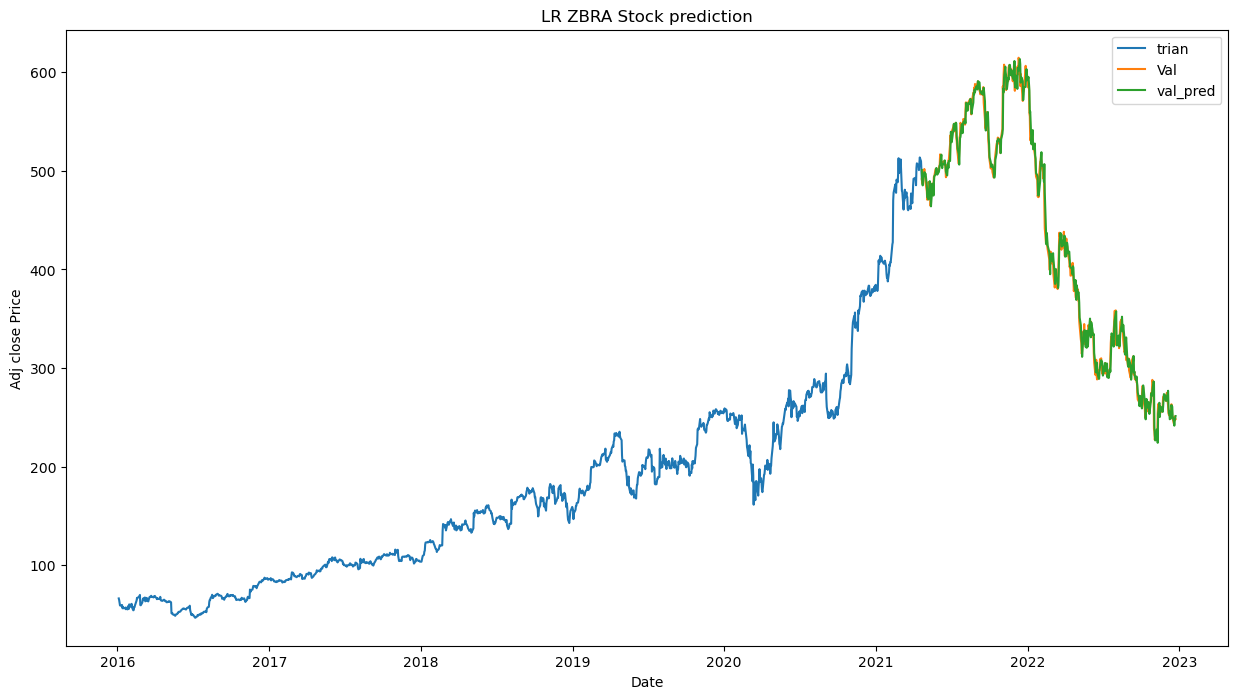

In [13]:
predictions,split_index,LR,X_test,y_test,scaler = build_lr(df,'ZBRA')
plot_result(df,'ZBRA',predictions ,split_index,'LR')

In [15]:
def prediction_future(X_test,y_test,time_step=60):
    temp1 = X_test[-1][1:].tolist()
    predictions = y_test[-1].tolist()
    temp1.extend(predictions)
  
    for i in range(30):
        if len(temp1)==time_step:
            temp1 = np.array(temp1).reshape(-1,time_step)
            predic = LR.predict(temp1)
            temp1 = temp1.tolist()
            predic = predic[0].tolist()
            temp1[0].extend(predic)
            predictions.extend(predic)
            print('done')
        else:
            temp1 = temp1[0][1:]
            temp1 = np.array(temp1).reshape(-1,time_step)
            predic = LR.predict(temp1)
            temp1 = temp1.tolist()
            predic = predic[0].tolist()
            temp1[0].extend(predic)
            predictions.extend(predic)
    return predictions

In [16]:
predictions = prediction_future(X_test,y_test)

done


In [17]:
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))

In [18]:
def show_result(predictions,ticker):
    week = float(predictions[7] / predictions[0] *100-100)
    two_week = float(predictions[14] / predictions[0] *100-100)
    month = float(predictions[-1] / predictions[0] *100-100)
    print(f'regarding to price today {round(float(predictions[0]),2)}$ for {ticker}')
    print(f'predicted stock value for 7 days  is  : {round(week,2)} %')
    print(f'predicted stock value for 14 days is  : {round(two_week,2)} %')
    print(f'predicted stock value for 30 days is  : {round(month,2)} %')

In [19]:
show_result(predictions,'ZBRA')

regarding to price today 248.22$ for ZBRA
predicted stock value for 7 days  is  : 0.61 %
predicted stock value for 14 days is  : -0.57 %
predicted stock value for 30 days is  : -2.27 %


# Portfolio Optimization
<img src="image/portfolio_opt.jpg">


In [4]:
df = get_data(all_tickers)


[*********************100%***********************]  193 of 193 completed


In [20]:
data = df[:'2018-12-31']# filter data
# Drop nan value 
data.dropna(axis=1,inplace = True)

In [22]:
def port_opt(df):
    intention = int(input("input\n1 for maximun sharpe ratio\n2 for minimun risk\n3 for maximum return\n"))
    total_value = int(input('How much would you invest $'))
    print()
    mu = mean_historical_return(df)
    S = risk_models.sample_cov(df)
    ef = EfficientFrontier(mu, S)
    ef.add_objective(objective_functions.L2_reg, gamma=1)
    if intention == 1:
        ef.max_sharpe()
    elif intention == 2 :
        ef.min_volatility()
    else:
        ef._max_return()
    cleaned_weights = ef.clean_weights()
    ef.portfolio_performance(verbose=True)
    print()
    latest_prices = get_latest_prices(df)
    da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=total_value)
    allocation, leftover = da.greedy_portfolio()
    name = pd.read_csv('nasdaq_screener.csv')[['Symbol','Name']]
    name.columns = ['Ticker','Name']
    alloc = pd.DataFrame(allocation.items(),columns=['Ticker','Numbers_of_shares'])
    alloc['Allocation'] = round(alloc['Numbers_of_shares'] / alloc['Numbers_of_shares'].sum(),4)*100
    alloc = pd.merge(alloc,name,how='left',on='Ticker')
  
    if len(alloc) > 0:
        print('Orderd Allocation\n',alloc.to_string())
        print('Left over : $',int(leftover))

    else:
        print('Low money')
        port_opt(df)


### maximun sharpe ratio

In [8]:
port_opt(data)

input
1 for maximun sharpe ratio
2 for minimun risk
3 for maximum return
1
How much would you invest $2000

Expected annual return: 40.4%
Annual volatility: 18.0%
Sharpe Ratio: 2.14

Orderd Allocation
    Ticker  Numbers_of_shares  Allocation                                             Name
0    ETSY                  2        6.67                           Etsy Inc. Common Stock
1     AMD                  6       20.00         Advanced Micro Devices Inc. Common Stock
2    ABMD                  1        3.33                        ABIOMED Inc. Common Stock
3     CZR                  2        6.67          Caesars Entertainment Inc. Common Stock
4    NVDA                  2        6.67                  NVIDIA Corporation Common Stock
5     CME                  1        3.33              CME Group Inc. Class A Common Stock
6    MTCH                  1        3.33                    Match Group Inc. Common Stock
7    TTWO                  1        3.33  Take-Two Interactive Software Inc. C

<img src="image/max_sharpe.jpg">
<img src="image/max_sharpe_growth.jpg">



### minimun risk

In [11]:
port_opt(data)

input
1 for maximun sharpe ratio
2 for minimun risk
3 for maximum return
2
How much would you invest $2000

Expected annual return: 12.5%
Annual volatility: 12.2%
Sharpe Ratio: 0.86

Orderd Allocation
    Ticker  Numbers_of_shares  Allocation                                               Name
0     XEL                  1        3.33                      Xcel Energy Inc. Common Stock
1     AEP                  1        3.33  American Electric Power Company Inc. Common Stock
2     LNT                  1        3.33            Alliant Energy Corporation Common Stock
3     KDP                  1        3.33                 Keurig Dr Pepper Inc. Common Stock
4     EXC                  1        3.33                    Exelon Corporation Common Stock
5     PEP                  1        3.33                          PepsiCo Inc. Common Stock
6     REG                  1        3.33           Regency Centers Corporation Common Stock
7    GLPI                  1        3.33    Gaming and Leisure

<img src="image/Min_Risk.jpg">
Because of the portfoliovisualizer free account accepts just 25 ticker for backtest so i choose first 25 ticker and add to allocation percentages
<img src="image/Min_Risk_growth.jpg">

### maximum return

In [12]:
port_opt(data)

input
1 for maximun sharpe ratio
2 for minimun risk
3 for maximum return
3
How much would you invest $2000

Expected annual return: 88.7%
Annual volatility: 69.8%
Sharpe Ratio: 1.24

Orderd Allocation
   Ticker  Numbers_of_shares  Allocation                                      Name
0    AMD                108       100.0  Advanced Micro Devices Inc. Common Stock
Left over : $ 6


<img src="image/Max_return.jpg">


By using the [PyPortfolioOpt](https://github.com/robertmartin8/PyPortfolioOpt) library to build a diversified portfolio and using the [portfolio visualizer](https://www.portfoliovisualizer.com/backtest-portfolio) site for backtesting the portfolio using the adjusted close price data of 193 tickers for mega and large companies from 2016 to 2018 for making a portfolio and backtest this portfolio for 2019, we found 
- The Max Sharpe ratio portfolio achieved 21% more than expected with the same risk in the backtest and with a close Sharpe ratio
- The Min Risk Portfolio achieved double return from 12.5% as ecpected to 27% and lower risk than expected and with a higher Sharpe ratio
- The Max Return portfolio from 88% expected, it achieved 148% return with lower risk from 70% to 38% and Sharpe ratio 2.56 in the backtest but still very risky

# Justification
- We can see that we can predict future prices of stocks just by looking at their historical prices, there are many ML models that can predict stock prices, sometimes we found LSTM outperforms the LR model but LR is generally the best in this kind of data, just adjusted Closing price using this preprocessing techniques and LR is better due to less error and less time < 1 sec . LSTM can work better on other types of data such as using all the features from the dataset such as open, high, low, and close prices.
- And in portfolio optimization, we get satisfactory results from all types of portfolios, and the Max Returns portfolio yielded a very good return, but this is not a diversified portfolio so it is very risky to invest all your money in one stock or even in one sector.<br>
A diversified portfolio reduces risk through a variety of stocks that are not correlated.

# Conclusion
Exploring the data, I see that there are some sectors that have been affected less, in other words, they are non-cyclical and therefore relatively stable in both strong or weak economies such as basic materials, utilities, consumer staples, customer discretionary, where the energy sector fell during the pandemic, the other sector Like technology thrives.

# Improvements
- Try to build more models and get fewer errors than LR and LSTM, and try different preprocessing techniques for data and use more features than the adjusted close price<br>
- Build a web application that facilitates the process for users to access the model
- Improve the portfolio optimization to let the user exclude some sectors from processing and if he wants to build a portfolio in specific stocks 
